In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Concatenate
from tensorflow.keras.applications import InceptionV3, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
BATCH_SIZE = 128
image_height = 224
image_width = 224
input_shape = (image_height, image_width, 3)


In [6]:
data_generator_1 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    brightness_range=[0.95, 1.05],
    fill_mode='nearest'
)

data_generator_3 = ImageDataGenerator(rescale=1./255)


In [7]:
train_dir = r'C:\Users\DL\Music\JUPYTR FILES FOR RESEARCH\RESEARCH 03\dataset1\train'
test_dir = r'C:\Users\DL\Music\JUPYTR FILES FOR RESEARCH\RESEARCH 03\dataset1\test'

train_generator = data_generator_1.flow_from_directory(
    train_dir,
    target_size=(image_height, image_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

test_generator = data_generator_3.flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42
)


Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
class_labels = list(train_generator.class_indices.keys())
class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(zip(np.unique(train_generator.classes), class_weights_array))
class_weights_tensor = tf.constant(list(class_weights_dict.values()), dtype=tf.float32)


In [9]:
base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape, name='inception_base')
base_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape, name='mobilenet_base')

for model_base in [base_inception, base_mobilenet]:
    for layer in model_base.layers:
        layer.trainable = False


In [10]:
inception_feat = BatchNormalization()(Flatten()(base_inception.output))
mobilenet_feat = BatchNormalization()(Flatten()(base_mobilenet.output))


In [11]:
fused = Concatenate()([inception_feat, mobilenet_feat])


In [12]:
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(fused)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(len(class_labels), activation='softmax')(x)

model = Model(inputs=[base_inception.input, base_mobilenet.input], outputs=output_layer)


In [13]:
def weighted_categorical_crossentropy(y_true, y_pred):
    weights = tf.reduce_sum(class_weights_tensor * y_true, axis=-1)
    unweighted_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return unweighted_loss * weights


In [14]:
def double_input_generator(generator):
    while True:
        batch_x, batch_y = next(generator)
        yield (batch_x, batch_x), batch_y

train_gen = double_input_generator(train_generator)
val_gen = double_input_generator(test_generator)
def double_input_generator(generator):
    while True:
        batch_x, batch_y = next(generator)
        yield (batch_x, batch_x), batch_y

train_gen = double_input_generator(train_generator)
val_gen = double_input_generator(test_generator)


In [15]:
model.compile(optimizer='adam', loss=weighted_categorical_crossentropy, metrics=['accuracy'])

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)


In [17]:
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_generator),
    validation_data=val_gen,
    validation_steps=len(test_generator),
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1318s 17s/step - accuracy: 0.7995 - loss: 4.9499 - val_accuracy: 0.8870 - val_loss: 3.1153 - learning_rate: 0.0010
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1124s 15s/step - accuracy: 0.8420 - loss: 4.0357 - val_accuracy: 0.8975 - val_loss: 2.9501 - learning_rate: 0.0010
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1451s 19s/step - accuracy: 0.8653 - loss: 3.3376 - val_accuracy: 0.9287 - val_loss: 2.6761 - learning_rate: 0.0010
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 908s 12s/step - accuracy: 0.8826 - loss: 2.7884 - val_accuracy: 0.8910 - val_loss: 2.4340 - learning_rate: 0.0010
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 667s 9s/step - accuracy: 0.8980 - loss: 2.3538 - val_accuracy: 0.9180 - val_loss: 2.0166 - learning_rate: 0.0010
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 639s 8s/step - accuracy: 0.9135 - loss: 1.9629 - val_accuracy: 0.9400 - val_loss: 1.6791 - learning_rate: 0.0010
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 12259s 163s/step - accuracy: 0.9245 - loss: 1.650

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Classification Report:

              precision    recall  f1-score   support

      benign       1.00      0.97      0.98       128
   malignant       0.00      0.00      0.00         0

    accuracy                           0.97       128
   macro avg       0.50      0.48      0.49       128
weighted avg       1.00      0.97      0.98       128

Confusion Matrix:



C:\Users\DL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


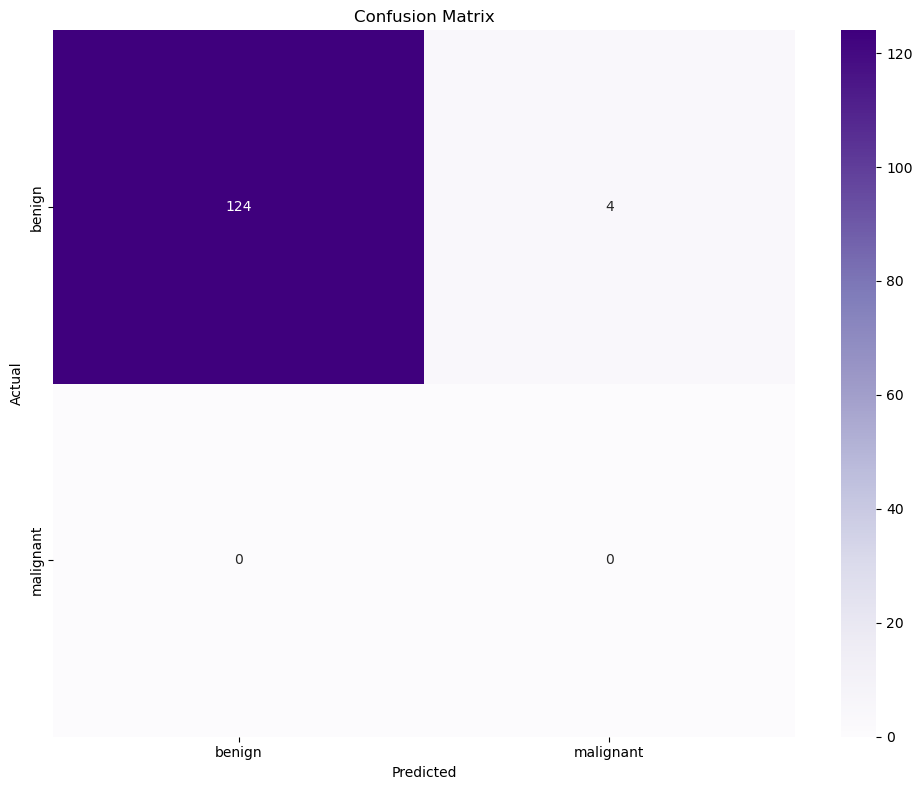

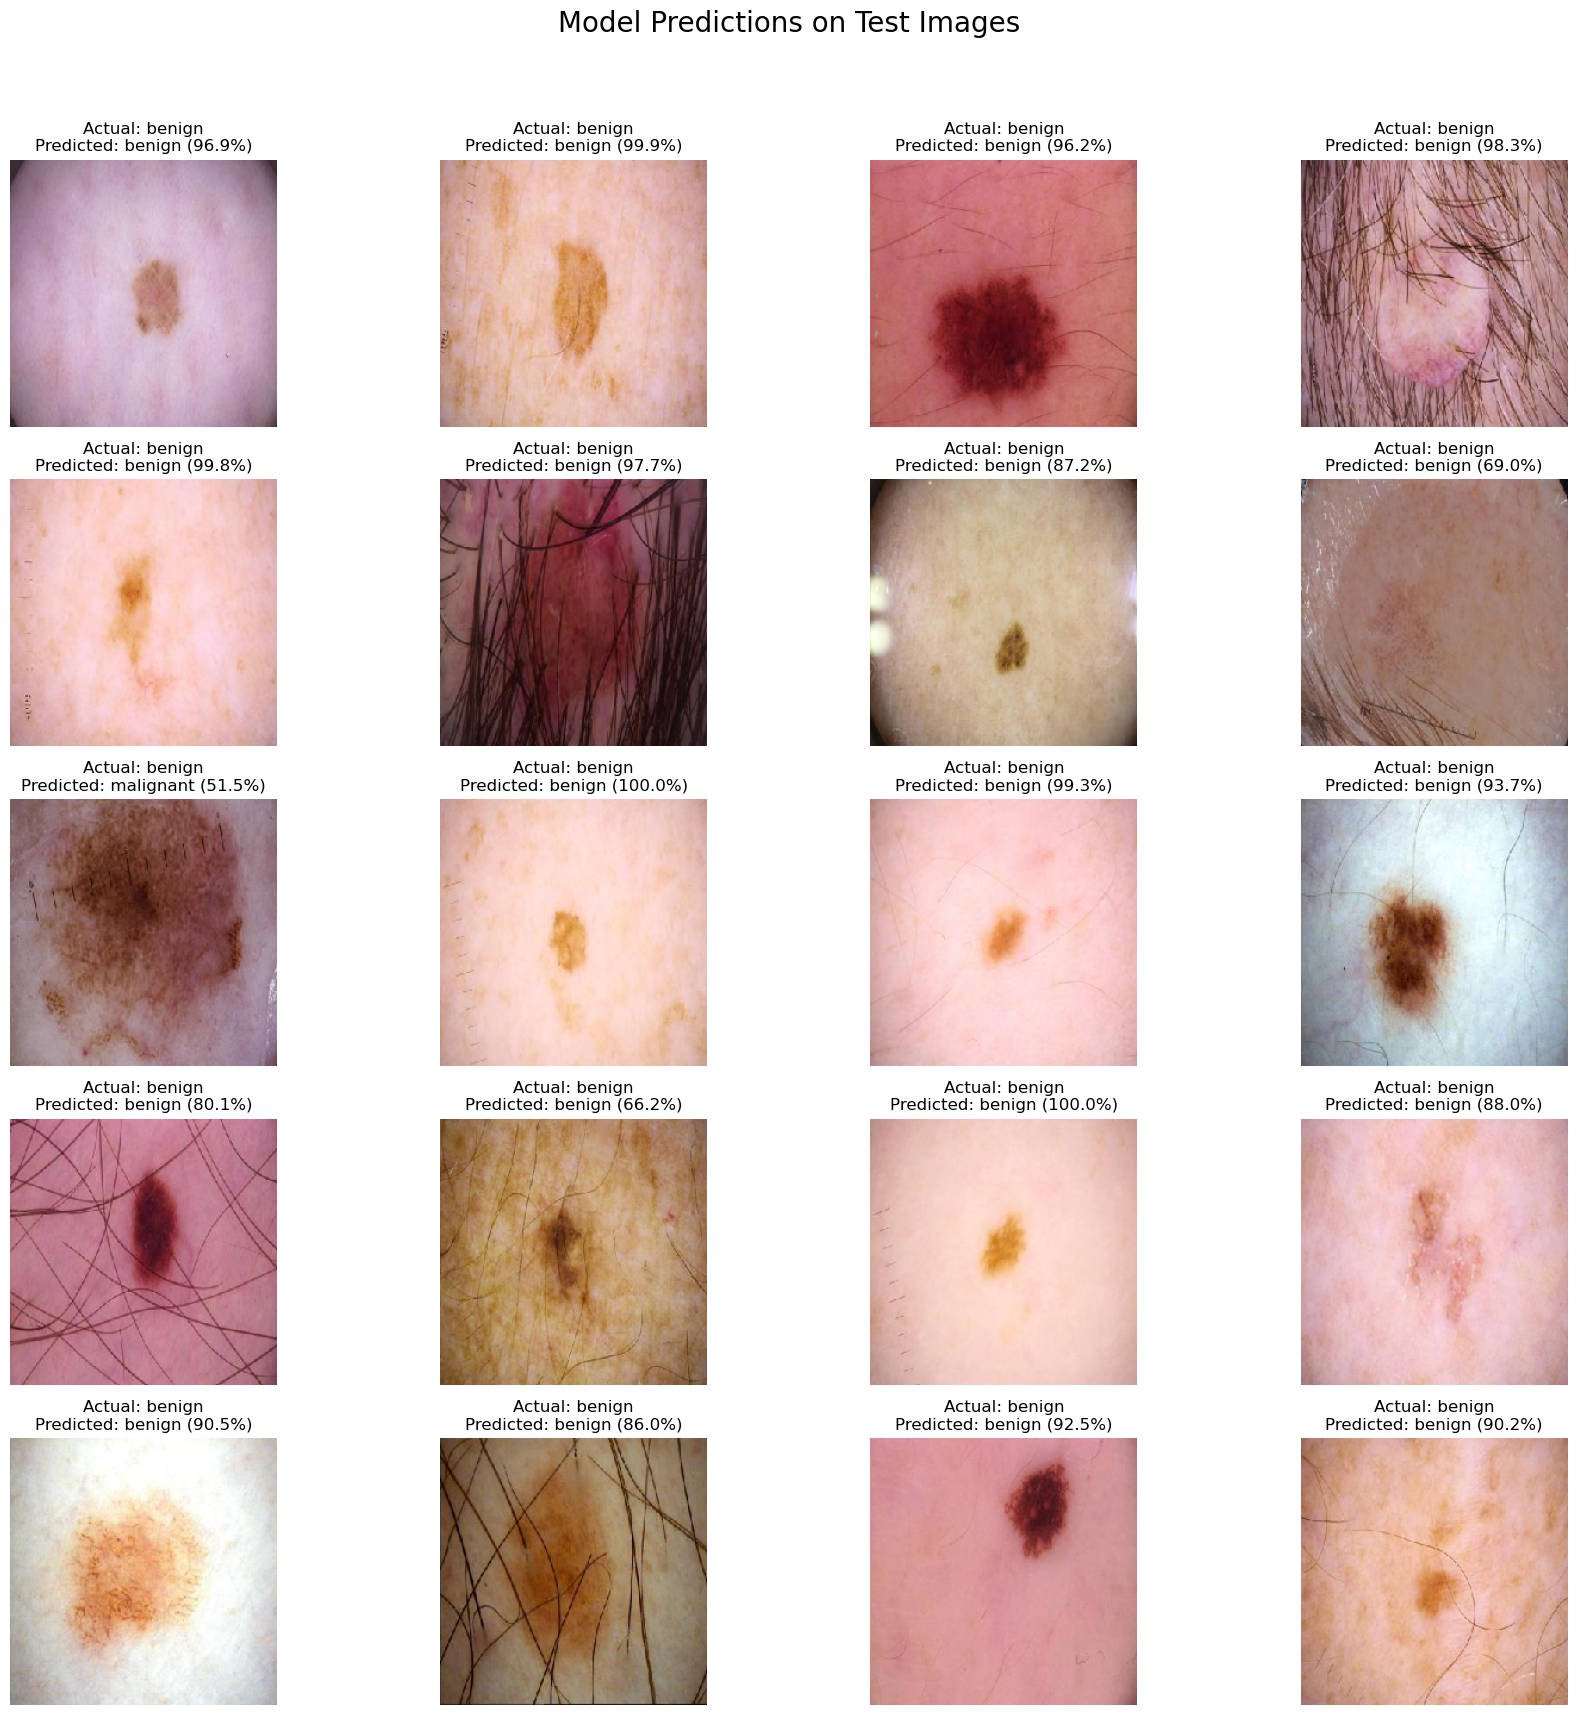

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Reset and fetch batch
test_generator.reset()
(img_batch, label_batch) = next(test_generator)
predictions = model.predict([img_batch, img_batch])

true_classes = np.argmax(label_batch, axis=1)
predicted_classes = np.argmax(predictions, axis=1)

# Print evaluation metrics
print("Classification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

print("Confusion Matrix:\n")
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Display sample images with predictions
plt.figure(figsize=(18, 18))
for i in range(20):  # Adjust number if needed
    plt.subplot(5, 4, i + 1)
    plt.imshow(img_batch[i])
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {} ({:.1f}%)".format(
        class_labels[true_classes[i]],
        class_labels[predicted_classes[i]],
        100 * np.max(predictions[i])
    ))

plt.suptitle("Model Predictions on Test Images", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [40]:
# ========== Imports ==========

# ========== Setup ==========

# ========== Data Augmentation ==========

# ========== Generators ==========

# ========== Class Weights ==========

# ========== Model Building: InceptionV3 + MobileNetV2 Hybrid ==========

# Feature Extraction with Flatten + BatchNorm

# Feature Fusion

# Dense Layers

# ========== Custom Weighted Loss ==========

# ========== Compile Model ==========


# ========== Triple Input Generator ==========

# ========== Callbacks ==========

# ========== Train ==========

# ========== Plot Training History ==========



In [40]:
from sklearn.metrics import classification_report

# Flatten class_labels if they contain nested lists
class_labels = [item[0] if isinstance(item, list) else item for item in class_labels]

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)

# Extract and print just the overall metrics
macro = report['macro avg']
weighted = report['weighted avg']

print("\n========= Overall Model Performance =========")
print(f"Macro Average  — Precision: {macro['precision']:.3f}, Recall: {macro['recall']:.3f}, F1-score: {macro['f1-score']:.3f}")
print(f"Weighted Average  — Precision: {weighted['precision']:.3f}, Recall: {weighted['recall']:.3f}, F1-score: {weighted['f1-score']:.3f}")
print("=============================================")



========= Overall Model Performance =========
Macro Average  — Precision: 0.500, Recall: 0.484, F1-score: 0.492
Weighted Average  — Precision: 1.000, Recall: 0.969, F1-score: 0.984


C:\Users\DL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
